## Chapter 20 - Metric Predicted Variable with Multiple Nominal Predictors

- [20.2 - Hierarchical Bayesian Approach](#20.2---Hierarchical-Bayesian-Approach)
 - [20.2.3 - Main effect contrasts](#20.2.3---Main-effect-contrasts)
- [20.4 - Heterogenous Variances and Robustness against Outliers](#20.4---Heterogenous-Variances-and-Robustness-against-Outliers)
- 20.5 - Within-Subject Designs
 - [20.5.2 Split-plot design](#20.5.2---Split-plot-design)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

from scipy.stats import norm
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [3]:
def plot_mustache(var, sd, j, width=.75, ax=None):
    for i in np.arange(0, len(var), int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange*(width/xrange.max())
        
        # Using the negative value to flip the mustache in the right direction.
        ax.plot(-xrange_scaled+j, yrange, color=color, alpha=.6, zorder=99)

### 20.2 - Hierarchical Bayesian Approach

In [4]:
df = pd.read_csv('data/Salary.csv', usecols=[0,3,5], dtype={'Org': 'category', 'Pos': 'category'})

# Reorder the Pos categories and rename categories
df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 3 columns):
Org       1080 non-null category
Pos       1080 non-null category
Salary    1080 non-null int64
dtypes: category(2), int64(1)
memory usage: 13.8 KB


In [5]:
df.groupby('Pos').apply(lambda x: x.head(2))

Org      Pos  Salary
Pos                               
Assis   4    LGED    Assis   63796
        6    INFO    Assis   98814
Assoc   0      PL    Assoc   72395
        1    MUTH    Assoc   61017
Full    7    CRIN     Full  107745
        9     PSY     Full  173302
Endow   5    MGMT    Endow  219600
        8    CRIN    Endow  114275
Disting 29   SPEA  Disting  285000
        128  MUHI  Disting  114189

#### Model (Kruschke, 2015)

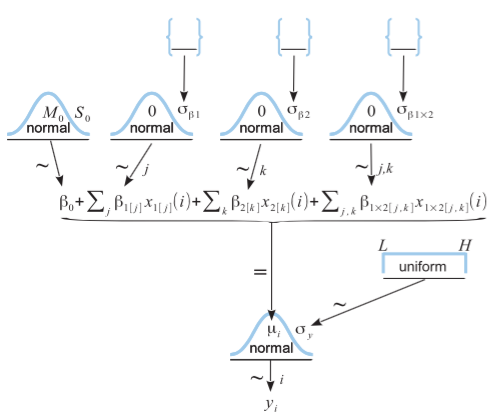

In [6]:
Image('images/fig20_2.png')

In [7]:
y = df.Salary
yMean = y.mean()
ySD = y.std()

x1 = df.Pos.cat.codes.values
Nx1Lvl = len(df.Pos.cat.categories)

x2 = df.Org.cat.codes.values
Nx2Lvl = len(df.Org.cat.categories)

agammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD)

with pm.Model() as model1:
    
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    
    a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
        
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    mu = a0 + a1[x1] + a2[x2] +a1a2[x1, x2]
    like = pm.Normal('like', mu, sd=ySigma, observed=y)    

In [ ]:
n_samples = 10000
with model1:
    trace1 = pm.sample(n_samples, nuts_kwargs={'target_accept':0.95})

In [ ]:
pm.traceplot(trace1);

In [ ]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, n_samples))
b1b2 = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace1['a0'] +
                     trace1['a1'][:,j1] +
                     trace1['a2'][:,j2] +
                     trace1['a1a2'][:,j1,j2])

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

# Below are the values corresponding to the first column of table 20.2
print('b0: {}'.format(np.round(np.mean(b0))))
print('b1: {}'.format(np.round(np.mean(b1, axis=1))))
print('b2: {}'.format(np.round(np.mean(b2, axis=1))[[20,48,12,7]]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,12]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,12]))
print('ySigma: {}'.format(np.round(np.mean(trace1['ySigma']))))

In [ ]:
burnin = 200
scale = trace1['ySigma']

# Figure 20.8 in the book shows the Salary data for four of the sixty departments.
# Let's create the subset for plotting. 
subset_org = ['BFIN', 'CHEM', 'PSY', 'ENG']
subset_df = df[df.Org.isin(subset_org)]

fg = sns.FacetGrid(subset_df, col='Org', col_order=subset_org,
                   col_wrap=2, size=3.5, aspect=1.3, despine=False, sharex=False) 
fg.map(sns.swarmplot, 'Pos', 'Salary', data=subset_df, color='r')
fg.fig.suptitle('Data with Posterior Prediction', y=1.05, fontsize=16)
for ax in fg.axes:
    ax.set_xlim(xmin=-1)
    ax.set_ylim(ymin=0)
    
for i, org_idx in enumerate([7,12,48,20]):
    for pos_idx in np.arange(5):
        plot_mustache(b0[burnin:]+
                      b1[pos_idx, burnin:]+
                      b2[org_idx,burnin:]+
                      b1b2[pos_idx,org_idx,burnin:], scale[burnin:], pos_idx, ax=fg.axes.flatten()[i])

### 20.2.3 - Main effect contrasts

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,4))

pm.plot_posterior((b1[1,burnin:])-(b1[0,burnin:]), color=color, point_estimate='mode', ax=ax1)
pm.plot_posterior(b2[12,burnin:]-b2[48,burnin:], color=color, point_estimate='mode', ax=ax2)
pm.plot_posterior(b2[7,burnin:]-np.mean([b2[48,burnin:],
                                          b2[12,burnin:],
                                          b2[20,burnin:]], axis=0), color=color, point_estimate='mode', ax=ax3);

### 20.4 - Heterogenous Variances and Robustness against Outliers

#### Model (Kruschke, 2015)

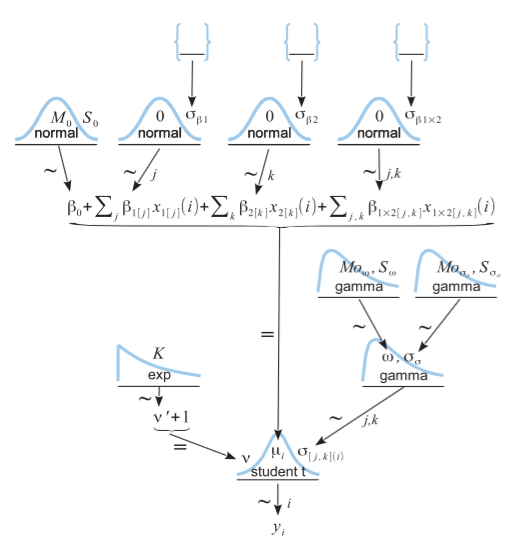

In [8]:
Image('images/fig20_7.png')

In [9]:
y = df.Salary

yMean = y.mean()
ySD = y.std()
aGammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD )

x1 = df.Pos.cat.codes.values
Nx1Lvl = len(df.Pos.cat.categories)

x2 = df.Org.cat.codes.values
Nx2Lvl = len(df.Org.cat.categories)

cellSDs = df.groupby(['Org','Pos']).std().dropna()
medianCellSD = cellSDs.median().squeeze()
sdCellSD = cellSDs.std().squeeze()
sgammaShRa = gammaShRaFromModeSD(medianCellSD, 2*sdCellSD)

with pm.Model() as model2:
    
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    
    a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
        
    mu = a0 + a1[x1] + a2[x2] +a1a2[x1, x2]
             
    sigmaMode = pm.Gamma('sigmaMode', sgammaShRa[0], sgammaShRa[1]) 
    sigmaSD = pm.Gamma('sigmaSD', sgammaShRa[0], sgammaShRa[1]) 
    sigmaRa = pm.Deterministic('sigmaRa', (sigmaMode + tt.sqrt(sigmaMode**2 + 4*sigmaSD**2)) / (2*sigmaSD**2))
    sigmaSh = pm.Deterministic('sigmaSh', (sigmaMode * sigmaRa))
    sigma = pm.Gamma('sigma', sigmaSh, sigmaRa, shape=(Nx1Lvl, Nx2Lvl))
    ySigma = pm.Deterministic('ySigma', tt.maximum(sigma, medianCellSD/1000))
          
    nu = pm.Exponential('nu', 1/30.)
        
    like = pm.StudentT('like', nu, mu, sd=ySigma[x1, x2], observed=y)    

In [ ]:
# Using variational inference, since NUTS sampler seems to get stuck with this model.
with model2:
    means, sds, elbos = pm.variational.advi(n=10000)

In [ ]:
n_samples = 1000
with model2:
    step = pm.NUTS(scaling=means)
    trace2 = pm.sample(n_samples, step=step, start=means)

In [ ]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, n_samples))
b1b2 = m.copy()
sigma = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace3['a0'] +
                     trace3['a1'][:,j1] +
                     trace3['a2'][:,j2] +
                     trace3['a1a2'][:,j1,j2])
        sigma[j1,j2] = trace3['ySigma'][:,j1,j2]

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

print('b0: {}'.format(np.round(np.mean(b0))))
print('b1: {}'.format(np.round(np.mean(b1, axis=1))))
print('b2: {}'.format(np.round(np.mean(b2, axis=1), decimals=3)[[20,48,12,7]]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[0,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[2,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[0,12]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[2,12]))

In [ ]:
burnin = 20
scale = sigma

# Figure 20.8 in the book shows the Salary data for four of the sixty departments.
# Let's create the subset for plotting. 
subset_org = ['BFIN', 'CHEM', 'PSY', 'ENG']
subset_df = df[df.Org.isin(subset_org)]

fg = sns.FacetGrid(subset_df, col='Org', col_order=subset_org,
                   col_wrap=2, size=3.5, aspect=1.3, despine=False, sharex=False) 
fg.map(sns.swarmplot, 'Pos', 'Salary', data=subset_df, color='r')
fg.fig.suptitle('Data with Posterior Prediction', y=1.05, fontsize=16)
for ax in fg.axes:
    ax.set_xlim(xmin=-1)
    ax.set_ylim(ymin=0)
    
for i, org_idx in enumerate([7,12,48,20]):
    for pos_idx in np.arange(5):
        plot_mustache(b0[burnin:]+
                      b1[pos_idx, burnin:]+
                      b2[org_idx, burnin:]+
                      b1b2[pos_idx,org_idx,burnin:], sigma[pos_idx, org_idx, burnin:], pos_idx, ax=fg.axes.flatten()[i])

### 20.5.2 - Split-plot design

In [10]:
df2 = pd.read_csv('data/SplitPlotAgriData.csv')
df2.Field = df2.Field.astype('category')
df2.Till = df2.Till.astype('category')
df2.Fert = df2.Fert.astype('category')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
Field    99 non-null category
Till     99 non-null category
Fert     99 non-null category
Yield    99 non-null int64
dtypes: category(3), int64(1)
memory usage: 2.9 KB


In [11]:
df2.head()

,Field,Till,Fert,Yield
0,1,Chisel,Broad,119
1,1,Chisel,Deep,130
2,1,Chisel,Surface,123
3,2,Chisel,Broad,135
4,2,Chisel,Deep,148


#### Model

In [12]:
y = df2.Yield

xBetween = df2.Till.cat.codes.values
xBetweenLvl = df2.Till.cat.categories
NxBetweenLvl = len(xBetweenLvl)

xWithin = df2.Fert.cat.codes.values
xWithinLvl = df2.Fert.cat.categories
NxWithinLvl = len(xWithinLvl)

xSubject = df2.Field.cat.codes.values
xSubjectLvl = df2.Field.cat.categories
NxSubjectLvl = len(xSubjectLvl)

yMean = y.mean()
ySD = y.std()

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model3:
    sigmaBxW = pm.Gamma('sigmaBxW', agammaShRa[0], agammaShRa[1])
    aBxW = pm.Normal('aBxW', mu=0.0, tau=1/sigmaBxW**2, shape=(NxBetweenLvl, NxWithinLvl))
    
    sigmaS = pm.Gamma('sigmaS', agammaShRa[0], agammaShRa[1])
    aS = pm.Normal('aS', mu=0.0, tau=1/sigmaS**2, shape=NxSubjectLvl)
    
    sigmaW = pm.Gamma('sigmaW', agammaShRa[0], agammaShRa[1])
    aW = pm.Normal('aW', mu=0.0, tau=1/sigmaW**2, shape=NxWithinLvl)
    
    sigmaB = pm.Gamma('sigmaB', agammaShRa[0], agammaShRa[1])
    aB = pm.Normal('aB', mu=0.0, tau=1/sigmaB**2, shape=NxBetweenLvl)
    
    a0 = pm.Normal('a0', mu=yMean, tau=1/(ySD*5)**2)
    sigma = pm.Uniform('sigma', ySD/100, ySD*10)
    
    mu = a0 + aB[xBetween] + aW[xWithin] + aS[xSubject] + aBxW[xBetween, xWithin]
    
    like = pm.Normal('like', mu=mu, tau=1/sigma**2, observed=y)

In [13]:
with model3:
    trace3 = pm.sample(2500, nuts_kwargs={'target_accept':.97})

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 394.37: 100%|██████████| 200000/200000 [00:53<00:00, 3754.46it/s]
Finished [100%]: Average Loss = 394.38
100%|██████████| 3000/3000 [02:13<00:00, 22.52it/s]


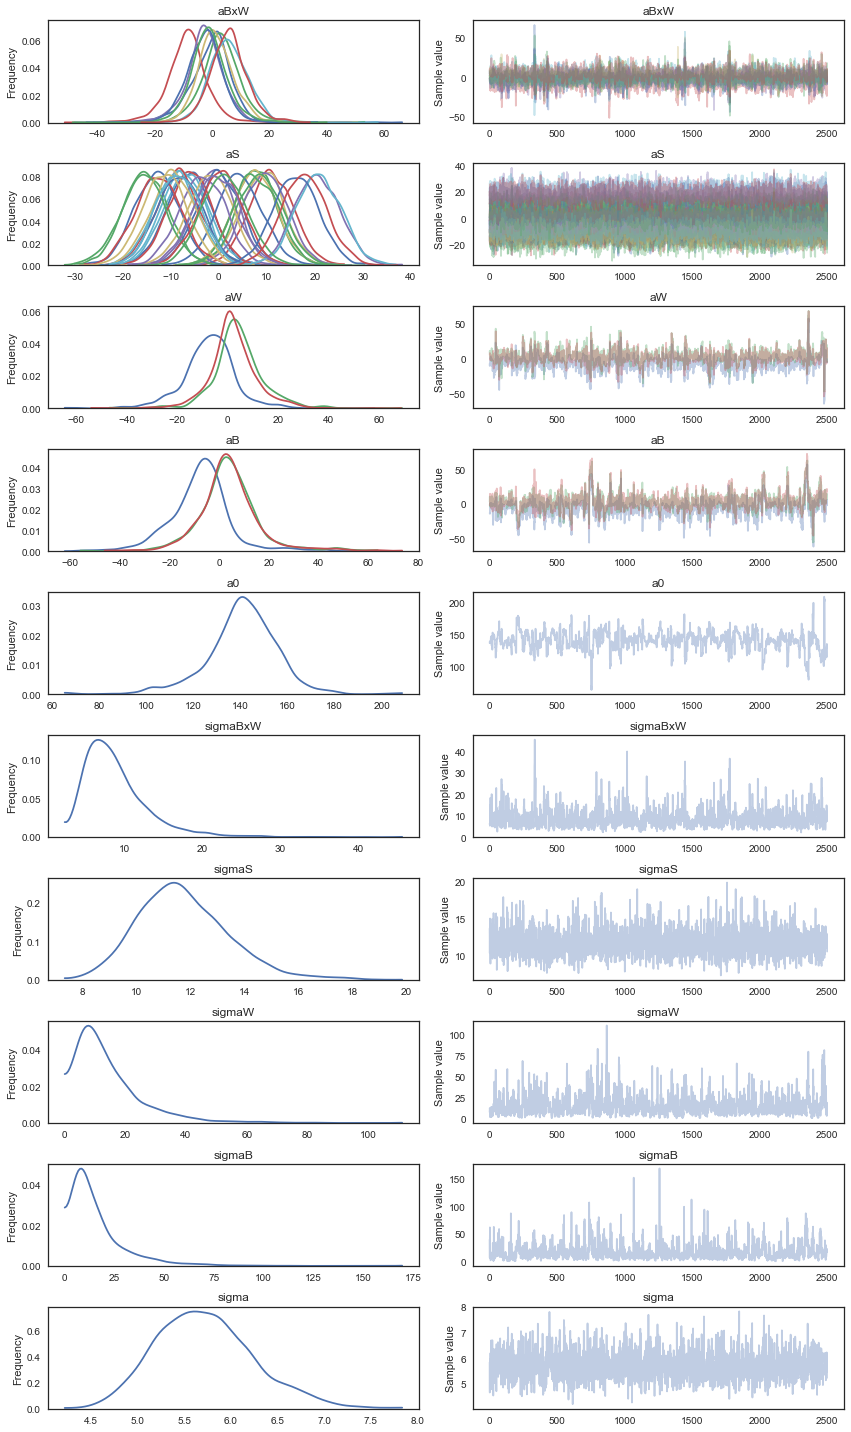

In [15]:
pm.traceplot(trace3);

In [14]:
a0 = trace3['a0']
aB = trace3['aB']
aW = trace3['aW']
aBxW = trace3['aBxW']
aS = trace3['aS']
sigma = trace3['sigma']

### Marginal means and sum-to-zero deflections

I found this bit the most challenging to understand. However, the Numpy code is somewhat cleaner than the code in JAGS.

Note: In contrast to the JAGS code, we recenter the deflections after sampling. That is why there is an extra dimension with all trace values.

In [16]:
# Let's put all the cell values in a multi-dimensional array.
# Dimension 1: SubjectLvl (Field)
# Dimension 2: BetweenLvl (Tilling method)
# Dimension 3: WithinLvl (Fertilization method)
# Dimension 4: The corresponing mu values for the entire trace

mSxBxW = np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl, len(trace3)))

for k, i, j in zip(xSubject, xBetween, xWithin):
    mu = a0 + aB[:,i] + aW[:,j] + aBxW[:,i,j] + aS[:,k]
    mSxBxW[k,i,j,:] = mu

Convert to Numpy masked arrays, with the values '0' being masked. This helps with calculating means along the different axis: masked values (= empty cells) are not taken into account!

In [17]:
mSxBxW_ma = ma.masked_equal(mSxBxW, 0)
mSxBxW_ma.shape

(33, 3, 3, 2500)

#### Calculating the cell means

In [18]:
mS = ma.mean(mSxBxW_ma, axis=(2))
mS.data.shape

(33, 3, 2500)

In [19]:
mBxW = mSxBxW_ma.mean(axis=(0))
mBxW.data.shape

(3, 3, 2500)

In [21]:
# Keeping the dimension of axis 1 in order to have the broadcasting work when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
mB.data.shape

(3, 1, 2500)

In [34]:
# Keeping the dimension of axis 1 in order to have the broadcasting work when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
mW.shape

(1, 3, 2500)

#### Converting to sum-to-zero

Equation 20.3

In [35]:
m = ma.mean(mBxW, axis=(0,1))
b0 = m
b0.mean()

140.44079884683316

Equation 20.4

In [33]:
# Removing the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m
bB.data.mean(1)

array([-10.54789175,   5.4740055 ,   5.07388626])

Equation 20.5

In [40]:
# Removing the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m
bW.data.mean(1)

array([-9.33712369,  6.24045658,  3.09666711])

Equation 20.6

In [36]:
bBxW = mBxW - mB - mW + m
bBxW.data.mean(2)

array([[ 3.65497038, -2.24808458, -1.4068858 ],
       [ 4.00501313, -1.13516297, -2.86985016],
       [-7.65998351,  3.38324755,  4.27673596]])

Equation 20.7

In [39]:
bS = mS - mB.squeeze()
bS.data.mean(2)

array([[ -5.39495409,   0.        ,   0.        ],
       [  8.41423315,   0.        ,   0.        ],
       [ 11.85054486,   0.        ,   0.        ],
       [ -0.05406357,   0.        ,   0.        ],
       [ 10.06623657,   0.        ,   0.        ],
       [ -5.84880688,   0.        ,   0.        ],
       [-12.16824816,   0.        ,   0.        ],
       [-14.24700539,   0.        ,   0.        ],
       [ -5.09443525,   0.        ,   0.        ],
       [ 10.65004715,   0.        ,   0.        ],
       [  8.46461694,   0.        ,   0.        ],
       [ -6.63816533,   0.        ,   0.        ],
       [  0.        ,   3.74600657,   0.        ],
       [  0.        ,   8.0004741 ,   0.        ],
       [  0.        ,  -9.16856612,   0.        ],
       [  0.        ,  19.90182494,   0.        ],
       [  0.        ,  -2.34378148,   0.        ],
       [  0.        ,  -9.60027438,   0.        ],
       [  0.        ,  -0.5402472 ,   0.        ],
       [  0.        ,   7.15728

#### Figure 20.10

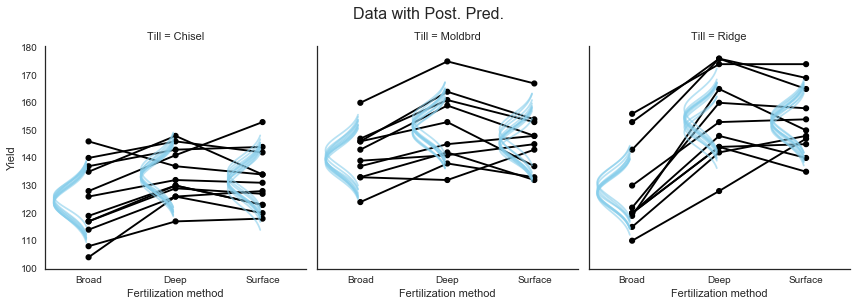

In [41]:
g = sns.FacetGrid(df2, col='Till', hue='Field', size=4)
g.map(sns.pointplot, 'Fert', 'Yield', color='k', scale=0.6)

for i, j in np.ndindex(NxBetweenLvl, NxWithinLvl):
    plot_mustache(b0+
                  bB[i,:]+
                  bW[j,:]+
                  bBxW[i,j,:],
                  sigma,
                  j, width= 0.4, ax=g.axes.flatten()[i])

for ax in g.axes.flatten():
    ax.set_xlabel('Fertilization method')
    
g.fig.suptitle('Data with Post. Pred.', y=1.05, fontsize=16);